# Keras starter kit [full training set, UNet]

## Setup

In [99]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from tqdm import tqdm
import cv2

# Data config
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 64  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 32  # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 16  # Offset of slices in the z direction
SHARED_HEIGHT = 2000  # Height to resize all papyrii

# (x, y)
val_location = (600, 500)
val_zone_size = (2000, 1000)

# Model config
BATCH_SIZE = 64
USE_MIXED_PRECISION = True
USE_JIT_COMPILE = False

threshold = 0.2

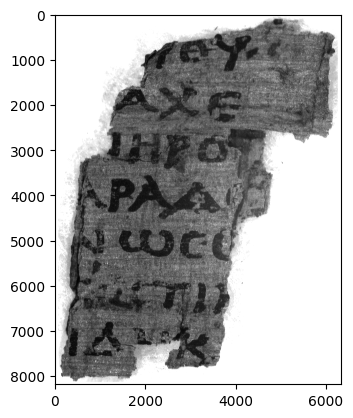

In [100]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

## Load up the training data

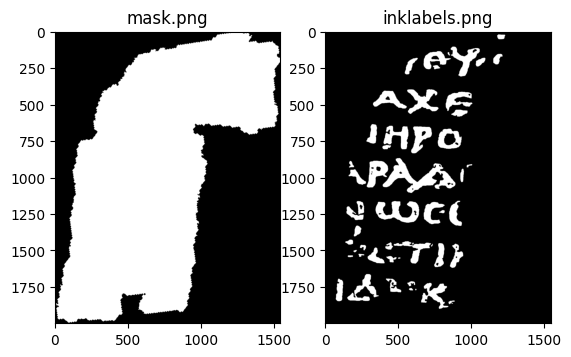

In [101]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0)
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0)
    img = resize(img)
    return img


mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [102]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

mask_test_a: (2000, 4642)
mask_test_b: (2000, 2321)
-
mask_train_1: (2000, 1547)
labels_train_1: (2000, 1547)
-
mask_train_2: (2000, 1281)
labels_train_2: (2000, 1281)
-
mask_train_3: (2000, 1380)
labels_train_3: (2000, 1380)


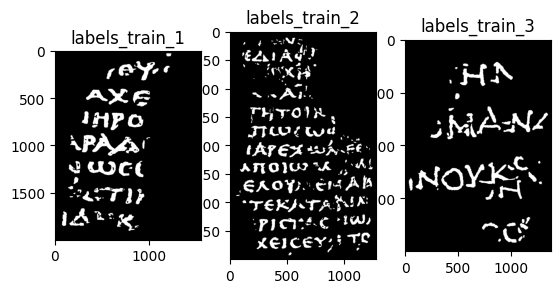

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [104]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [105]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

32it [00:02, 11.47it/s]


volume_train_1: (2000, 1547, 32), uint16


32it [00:06,  4.91it/s]


volume_train_2: (2000, 1281, 32), uint16


32it [00:02, 15.14it/s]


volume_train_3: (2000, 1380, 32), uint16
total volume: (2000, 4208, 32)


In [106]:
del volume_train_1
del volume_train_2
del volume_train_3

In [107]:
labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: (2000, 4208), uint8
mask: (2000, 4208), uint8


In [108]:
# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

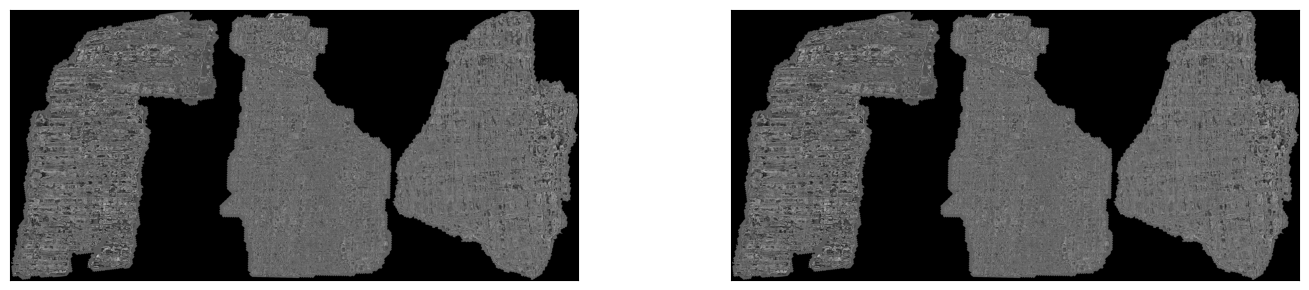

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Selection a validation holdout area

We set aside some fraction of the input to validate our model on.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


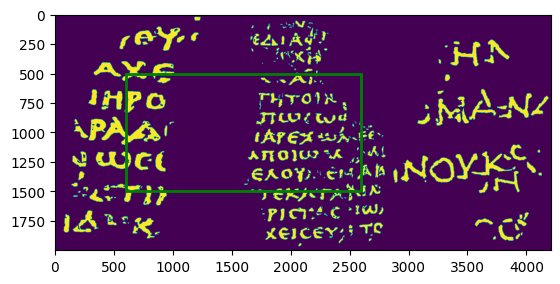

In [110]:
fig, ax = plt.subplots()
print(labels)
ax.imshow(labels)
patch = patches.Rectangle([val_location[0], val_location[1]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

Our training dataset will grab random patches within the masked area and outside of the validation area.

In [131]:
def sample_random_location(shape):
    random_train_x = np.random.random_integers(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
    random_train_y = np.random.random_integers(low=BUFFER, high=shape[1] - BUFFER - 1, size=())
    random_train_location = np.stack([random_train_x, random_train_y], axis=0)
    return random_train_location


def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

# Create a list to store train locations
train_locations = []

# Define the number of train locations you want to generate
num_train_locations = 10000

# Generate train locations
while len(train_locations) < num_train_locations:
    location = sample_random_location_train(0)
    if is_proper_train_location(location):
        train_locations.append(location)

# Convert the list of train locations to a PyTorch tensor
train_locations_ds = np.stack(train_locations, axis=0)

/tmp/ipykernel_1561470/985619578.py:2: DeprecationWarning: This function is deprecated. Please call randint(64, 1935 + 1) instead
  random_train_x = np.random.random_integers(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
/tmp/ipykernel_1561470/985619578.py:3: DeprecationWarning: This function is deprecated. Please call randint(64, 4143 + 1) instead
  random_train_y = np.random.random_integers(low=BUFFER, high=shape[1] - BUFFER - 1, size=())


## Visualize some training patches

Sanity check visually that our patches are where they should be.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

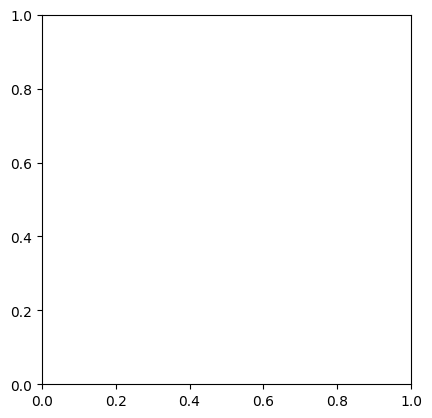

In [132]:
fig, ax = plt.subplots()
ax.imshow(labels)

# Define the number of samples you want to take from train_locations_ds
num_samples = 200

# Iterate over the first 'num_samples' elements in train_locations_ds
for i in range(num_samples):
    x, y = train_locations_ds[i]
    patch = Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[0], val_location[1]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [ ]:
from scipy.stats import median_abs_deviation


def extract_subvolume(location, volume):
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :] 
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    median = np.median(subvolume, axis=2)
    MAD = median_abs_deviation(subvolume, axis=2)
    # print("median", median)
    # print("MAD", MAD)
    if np.all(median != 0):        
        median = np.stack([median for i in range(Z_DIM)], axis=2)
        MAD = np.stack([MAD for i in range(Z_DIM)], axis=2)
        # print("mda.shape", MDA.shape, "MD", MDA)
        subvolume = (subvolume.astype(np.float32) - median) / MAD
    else:
        subvolume = subvolume.astype(np.float32) / 65536.
    return subvolume

## Create training dataset that yields random subvolumes and their labels

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool):
        self.locations = locations
        self.volume = volume
        self.labels = labels
        self.buffer = buffer
        self.is_train = is_train

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        location = self.locations[idx]
        x, y = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)        
        # subvolume = subvolume.numpy()
        # print(subvolume)
        # →H, W, C        
        subvolume = np.transpose(subvolume, (1, 0, 2)).astype(np.float32)                
        subvolume = subvolume.copy()
        
        if self.is_train:            
            label = self.labels[x - self.buffer:x + self.buffer, y - self.buffer:y + self.buffer]        
            # label = label.numpy()
            label = np.transpose(label, (1, 0)).astype(np.float32)
            label = np.stack([label], axis=-1)
            # n_category = 2
            # label = np.eye(n_category)[label]
            label = label.copy().astype(np.float32)
            
            performed = A.Compose([                
                A.RandomBrightnessContrast(),
                A.RandomBrightnessContrast(),
                A.HorizontalFlip(),
                A.VerticalFlip(),  
            ])(image=subvolume, mask=label)          
            subvolume = performed["image"]
            label = performed["mask"]
            # →C, H, W
            subvolume = torchvision.transforms.ToTensor()(subvolume)
            label = torchvision.transforms.ToTensor()(label)
            # print(performed)
            # print(subvolume.shape, label.shape)
        else:
            subvolume = torchvision.transforms.ToTensor()(subvolume)
            label = None
        return subvolume, label

# Convert train_locations_ds to a PyTorch tensor
train_locations_tensor = np.stack([x for x in train_locations_ds], axis=0)

# Create an instance of the SubvolumeDataset
train_ds = SubvolumeDataset(train_locations_tensor, volume, labels, BUFFER, is_train=True)

# Create a DataLoader with the dataset
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)


In [ ]:
subvolume_batch, label_batch = train_ds[1]
print(f"subvolume shape: {subvolume_batch.shape}")
print(f"label_batch shape: {label_batch.shape}")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In [ ]:
# t0 = time.time()
# n = 200
# for _ in train_ds:
#     pass
# print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

## Create validation dataset

In [ ]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

# Convert the list of val locations to a PyTorch tensor
val_locations_ds = torch.tensor(val_locations)

# Create an instance of the SubvolumeDataset
val_ds = SubvolumeDataset(val_locations_ds, volume, labels, BUFFER, is_train=True)

# Create a DataLoader with the dataset
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

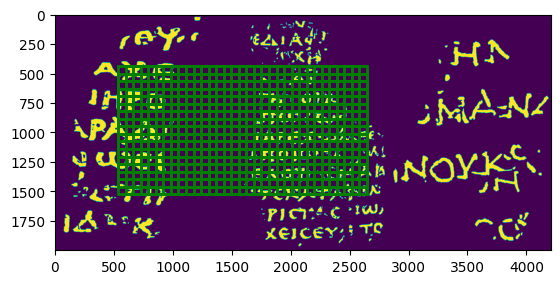

In [ ]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [ ]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.tensor(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

score = trivial_baseline(val_ds).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

  0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_1561470/1352218617.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_label = torch.tensor(batch_label)
  3%|▎         | 16/512 [00:00<00:06, 75.15it/s]

mean [[25300.5625  24557.875   26569.75    ... 23242.40625 25360.9375
  21609.25   ]
 [25762.625   23941.5625  26758.28125 ... 21216.15625 23756.15625
  19990.59375]
 [25866.21875 29045.96875 24131.9375  ... 21744.4375  28864.5625
  24228.5625 ]
 ...
 [24487.75    24024.3125  25792.3125  ... 28243.75    24974.71875
  20154.96875]
 [27891.1875  25208.875   25276.3125  ... 22132.65625 20865.375
  22121.90625]
 [25944.09375 24527.65625 22811.375   ... 18816.0625  20530.03125
  25565.     ]]
mean [[20624.53125 20642.6875  21311.46875 ... 22684.03125 24761.125
  23472.46875]
 [21972.625   23192.5625  28601.8125  ... 22501.28125 22827.34375
  23646.625  ]
 [26117.5625  23286.3125  24401.28125 ... 24871.15625 24639.34375
  25152.84375]
 ...
 [22406.71875 24673.1875  24116.0625  ... 29238.5     29017.3125
  29833.71875]
 [23278.78125 21513.9375  21263.5     ... 26180.9375  27181.5
  26534.03125]
 [21422.4375  22254.09375 22160.75    ... 26320.4375  26633.53125
  27530.9375 ]]
mean [[21718.    

  5%|▍         | 24/512 [00:00<00:06, 73.54it/s]

mean [[25132.1875  22139.125   26926.40625 ... 23864.5     23568.28125
  22142.25   ]
 [25366.5     20805.34375 23489.53125 ... 21818.375   23182.78125
  21982.28125]
 [21735.78125 22680.625   25584.125   ... 23262.9375  24375.96875
  23527.9375 ]
 ...
 [22990.9375  24057.96875 23144.      ... 26953.65625 26167.03125
  26241.71875]
 [22833.78125 22494.34375 21840.15625 ... 25929.65625 26327.09375
  26466.9375 ]
 [25277.5625  25472.5     23867.21875 ... 26193.5     27390.3125
  26693.3125 ]]
mean [[23812.21875 25185.84375 29703.0625  ... 21953.46875 21177.
  24118.875  ]
 [29562.96875 28159.75    28117.09375 ... 22192.28125 22996.25
  24457.40625]
 [26293.03125 28680.5625  25514.34375 ... 22437.9375  22680.34375
  21064.78125]
 ...
 [22105.9375  23648.25    23219.875   ... 22236.59375 22307.5
  22154.46875]
 [22395.15625 22065.03125 21882.96875 ... 22557.21875 23509.21875
  24843.65625]
 [26170.0625  27514.46875 26235.125   ... 26954.8125  25288.9375
  25071.78125]]
mean [[22666.125   2

  8%|▊         | 43/512 [00:00<00:05, 82.08it/s]

mean [[23176.34375 24043.5625  23403.96875 ... 22421.9375  21608.125
  24985.0625 ]
 [25287.28125 24489.71875 23211.6875  ... 23319.46875 23070.03125
  27179.03125]
 [22973.71875 22329.90625 21809.4375  ... 28401.90625 25155.9375
  28462.125  ]
 ...
 [28000.46875 30529.40625 28802.375   ... 23776.9375  24257.375
  24441.71875]
 [27042.3125  28166.71875 26541.96875 ... 24681.03125 23710.25
  22236.84375]
 [28538.78125 29530.03125 27356.3125  ... 23355.625   22489.21875
  22090.8125 ]]
mean [[25788.8125  24958.53125 24766.8125  ... 25688.75    24029.875
  25729.46875]
 [24669.      22668.3125  22688.4375  ... 24247.53125 25852.0625
  24254.5625 ]
 [26288.3125  24724.15625 24084.8125  ... 25366.78125 27970.5625
  27835.1875 ]
 ...
 [25163.78125 24574.28125 24680.5     ... 27265.8125  26241.875
  26036.59375]
 [27880.53125 28139.625   29018.      ... 26447.15625 27345.53125
  27135.625  ]
 [28824.625   25425.40625 22384.09375 ... 24884.75    24227.9375
  23815.25   ]]
mean [[22790.65625 23

 13%|█▎        | 65/512 [00:00<00:04, 91.81it/s]

mean [[24367.      24162.21875 23703.625   ... 26267.4375  25812.96875
  23620.375  ]
 [22755.      21685.15625 22793.      ... 28167.      28125.6875
  27062.     ]
 [21176.03125 20220.      22081.78125 ... 22106.71875 23750.46875
  24441.3125 ]
 ...
 [24361.09375 23893.46875 23463.34375 ... 24292.6875  25141.125
  24248.78125]
 [21946.59375 23310.09375 24228.15625 ... 23453.59375 24385.53125
  26078.0625 ]
 [24896.6875  25314.71875 26313.46875 ... 24491.125   25525.4375
  28977.40625]]
mean [[24788.375   25007.5     23079.34375 ... 26623.625   24813.28125
  22157.09375]
 [23719.9375  23433.53125 24099.9375  ... 20885.5625  21720.21875
  22867.9375 ]
 [24260.375   24397.53125 24230.71875 ... 21349.71875 20702.46875
  19776.28125]
 ...
 [27357.09375 25067.96875 22835.71875 ... 24621.28125 26156.46875
  27126.40625]
 [24823.6875  30938.53125 33312.9375  ... 25465.125   25146.9375
  22930.71875]
 [21509.5625  24685.4375  29545.46875 ... 25409.125   23222.1875
  23726.40625]]
mean [[23292

 17%|█▋        | 85/512 [00:00<00:04, 90.26it/s]

mean [[24695.      23165.34375 24232.5     ...     0.          0.
      0.     ]
 [20530.65625 22745.59375 24286.1875  ...     0.          0.
      0.     ]
 [25243.5     26632.8125  25126.71875 ...     0.          0.
      0.     ]
 ...
 [24125.21875 25296.71875 23705.375   ... 22235.34375 21115.5625
  24721.15625]
 [22739.6875  22072.75    21510.75    ... 22542.46875 21431.15625
  20801.25   ]
 [26386.375   25256.5625  24996.5625  ... 22474.21875 21297.75
  22418.375  ]]
mean [[24528.5     23171.09375 22072.71875 ...     0.          0.
      0.     ]
 [24960.25    23129.75    23320.59375 ...     0.          0.
      0.     ]
 [23050.90625 24463.1875  26382.375   ...     0.          0.
      0.     ]
 ...
 [26367.9375  27442.28125 26802.6875  ...     0.          0.
      0.     ]
 [26292.6875  27404.71875 26607.8125  ...     0.          0.
      0.     ]
 [26111.1875  25818.4375  25079.78125 ...     0.          0.
      0.     ]]
mean [[    0.          0.          0.      ...     0.  

 21%|██        | 106/512 [00:01<00:04, 89.21it/s]

mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[23723.53125 24292.3125  23842.5     ... 23079.25    23496.21875
  23726.71875]
 [25641.5625  23395.75    23337.625   ... 23213.46875 24333.875
  24673.46875]
 [24167.      24033.4375  2247

 25%|██▌       | 129/512 [00:01<00:03, 96.81it/s]

mean [[25745.8125  26465.96875 24939.84375 ... 28875.1875  26594.
  25804.3125 ]
 [26194.78125 27332.34375 26320.34375 ... 26576.84375 26861.5625
  23935.71875]
 [23104.65625 23030.96875 23582.03125 ... 27152.90625 26444.0625
  27125.5    ]
 ...
 [24011.90625 22940.4375  22335.90625 ... 24122.4375  24173.03125
  23536.21875]
 [25136.59375 25984.28125 25338.09375 ... 26091.96875 25401.3125
  22871.375  ]
 [24504.875   26259.375   26880.8125  ... 27487.28125 28481.875
  28507.71875]]
mean [[25190.71875 26215.21875 25844.15625 ... 23035.0625  24067.96875
  23510.6875 ]
 [22605.84375 24308.1875  23591.25    ... 24111.625   23070.78125
  22053.53125]
 [25916.53125 23795.1875  21111.65625 ... 25081.3125  24341.09375
  24674.9375 ]
 ...
 [23931.65625 23168.40625 22079.8125  ... 17682.0625  16252.46875
  17179.03125]
 [24706.46875 25886.78125 25297.21875 ... 29140.25    29191.96875
  30716.3125 ]
 [23053.21875 22952.3125  23198.75    ... 24461.3125  25788.59375
  23383.9375 ]]
mean [[27836.562

 29%|██▉       | 149/512 [00:01<00:03, 92.98it/s]

mean [[23620.40625 25064.375   25856.5     ... 25851.4375  25515.40625
  25832.53125]
 [24850.75    24095.53125 24151.34375 ... 27814.8125  26016.8125
  24624.3125 ]
 [23228.46875 23754.53125 24607.71875 ... 22061.0625  21666.5625
  22445.6875 ]
 ...
 [25931.375   25351.625   25347.34375 ... 22632.6875  21929.46875
  21741.34375]
 [19710.84375 19852.5     22753.3125  ... 26352.9375  26491.59375
  25163.40625]
 [26580.125   23836.96875 23983.4375  ... 24219.6875  25523.75
  24402.21875]]
mean [[24336.75    24344.15625 23253.5     ... 22983.3125  22092.09375
  21046.3125 ]
 [26568.40625 25617.5625  25431.875   ... 23320.875   22911.28125
  23009.375  ]
 [25969.125   26139.46875 24838.71875 ... 22636.625   22187.125
  22294.34375]
 ...
 [25286.875   27729.      28147.1875  ... 23217.34375 24305.53125
  22434.28125]
 [23343.65625 23927.6875  25973.90625 ... 23163.40625 22919.65625
  23380.1875 ]
 [25698.40625 26335.      25769.15625 ... 24108.75    24173.75
  25983.28125]]
mean [[26560.062

 31%|███▏      | 161/512 [00:01<00:03, 97.82it/s]

mean [[26212.6875  27144.75    25749.90625 ... 24909.28125 22109.875
  22141.9375 ]
 [23378.84375 20619.6875  23297.09375 ... 28195.4375  21917.4375
  23707.21875]
 [23895.71875 23605.28125 25064.      ... 24879.5625  18405.28125
  19388.78125]
 ...
 [20042.34375 19963.75    21590.875   ... 23526.5625  23851.71875
  22955.25   ]
 [24954.125   26645.4375  27924.59375 ... 24739.25    24485.8125
  23060.9375 ]
 [20555.78125 21363.0625  22663.375   ... 26480.4375  25012.28125
  24079.5    ]]
mean [[26485.375   25444.6875  25747.59375 ...     0.          0.
      0.     ]
 [24405.59375 24720.25    26444.8125  ...     0.          0.
      0.     ]
 [24773.78125 24989.84375 23140.6875  ...     0.          0.
      0.     ]
 ...
 [22731.625   22737.6875  22649.9375  ...     0.          0.
      0.     ]
 [22385.6875  21500.125   21903.90625 ...     0.          0.
      0.     ]
 [22383.71875 23314.4375  22191.625   ...     0.          0.
      0.     ]]
mean [[25290.96875 25049.40625 23628.343

 35%|███▌      | 181/512 [00:02<00:03, 93.86it/s]

mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[26288.3125  25685.8125  24517.71875 ... 24687.5     24856.5
  22634.     ]
 [23606.65625 26742.34375 27248.0625  ... 24375.34375 25394.53125
  24424.25   ]
 [26475.5625  22464.5625  20842.

 40%|███▉      | 203/512 [00:02<00:03, 93.04it/s]

mean [[23817.875   25366.      25961.84375 ... 24757.21875 23712.4375
  24514.75   ]
 [26716.4375  25319.40625 27782.6875  ... 25742.75    23696.71875
  22673.28125]
 [25308.34375 25887.65625 27211.46875 ... 24177.34375 23927.875
  24884.0625 ]
 ...
 [23547.96875 25270.15625 25364.5     ... 24051.625   22959.03125
  22942.875  ]
 [31951.09375 33349.90625 32481.59375 ... 25887.1875  27248.90625
  26110.65625]
 [24075.25    21649.875   23745.9375  ... 25044.03125 24541.8125
  26740.84375]]
mean [[28332.5625  28927.34375 28334.3125  ... 24158.09375 24556.90625
  25731.375  ]
 [25829.28125 28728.46875 29112.75    ... 23749.      23595.96875
  23277.03125]
 [25749.28125 25499.59375 26122.4375  ... 23187.875   21899.59375
  20858.     ]
 ...
 [29924.34375 25754.1875  28362.40625 ... 24181.8125  26191.40625
  23127.625  ]
 [22347.875   21064.375   21834.625   ... 24514.65625 24551.28125
  23948.125  ]
 [25572.0625  25883.28125 25024.03125 ... 29261.5     29160.59375
  27290.5    ]]
mean [[249

 44%|████▍     | 225/512 [00:02<00:02, 99.43it/s]

mean [[27897.90625 29516.78125 28145.625   ... 25891.875   27159.40625
  24720.15625]
 [17222.75    15619.84375 17722.625   ... 22203.0625  21792.25
  23923.15625]
 [26954.5     27503.      27126.40625 ... 25569.53125 22828.96875
  21737.78125]
 ...
 [19639.5     21566.46875 20956.71875 ... 27238.625   28186.4375
  24527.8125 ]
 [22914.78125 23030.96875 22245.75    ... 22801.40625 22263.53125
  22171.125  ]
 [18673.1875  17845.15625 17798.375   ... 24686.53125 27491.9375
  22228.5625 ]]
mean [[20761.3125  21471.75    18267.40625 ... 25780.8125  27045.40625
  27116.71875]
 [22132.75    21670.8125  19229.65625 ... 24173.      24688.0625
  24604.78125]
 [22248.09375 27330.90625 26471.75    ... 26315.65625 26060.8125
  26075.1875 ]
 ...
 [24918.46875 21471.53125 26140.65625 ... 19805.875   21264.1875
  21628.6875 ]
 [26286.0625  24881.46875 27770.71875 ... 24765.625   21481.71875
  22012.28125]
 [24857.15625 22915.3125  22856.4375  ... 22746.125   19759.75
  19494.90625]]
mean [[22800.7187

 48%|████▊     | 245/512 [00:02<00:02, 95.97it/s]

mean [[24645.53125 22799.5625  22316.15625 ... 23589.21875 23597.65625
  23705.84375]
 [23753.      20318.53125 20874.28125 ... 23439.8125  23435.15625
  23302.5    ]
 [21792.65625 25797.34375 26027.40625 ... 23457.5     23560.9375
  23391.21875]
 ...
 [24429.46875 25175.8125  26886.0625  ... 22719.75    23553.96875
  23657.40625]
 [22483.90625 22051.25    21438.15625 ... 22959.0625  23561.8125
  23686.90625]
 [18822.0625  19380.65625 19521.78125 ... 23118.      23808.125
  23695.71875]]
mean [[26407.625   26057.8125  27043.46875 ...     0.          0.
      0.     ]
 [23119.4375  23887.25    19794.8125  ...     0.          0.
      0.     ]
 [23209.6875  21561.0625  23112.90625 ...     0.          0.
      0.     ]
 ...
 [24502.375   23527.78125 24267.15625 ...     0.          0.
      0.     ]
 [23094.59375 23340.0625  24816.4375  ...     0.          0.
      0.     ]
 [30202.15625 28413.28125 25697.5625  ...     0.          0.
      0.     ]]
mean [[23620.75    23424.59375 23548.218

 52%|█████▏    | 268/512 [00:02<00:02, 98.23it/s] 

mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[26562.4375  26083.0625  24573.9375  ... 23182.21875 26880.34375
  30236.84375]
 [23457.      22832.09375 21312.15625 ... 27693.71875 26380.625
  28542.125  ]
 [26360.375   27647.0625  25790.71875 ... 23204.96875 22875.40625
  23159.03125]
 ...
 [21628.09375 24555.0625  20996.46875 ... 24898.      25210.5
  27600.09375]
 [26524.65625 24051.1875  22

 57%|█████▋    | 290/512 [00:03<00:02, 102.48it/s]

mean [[25826.40625 24349.8125  24751.5     ... 37903.15625 34104.46875
  30256.84375]
 [24665.5625  25407.875   25395.34375 ... 33517.125   23417.5
  18050.6875 ]
 [25638.28125 23306.09375 23053.09375 ... 32386.96875 30646.9375
  28755.53125]
 ...
 [23444.1875  24287.      22391.40625 ... 22633.90625 23373.125
  24126.375  ]
 [22700.      23744.03125 25240.28125 ... 23779.      22289.25
  21295.40625]
 [21916.25    21638.40625 23725.5     ... 21424.96875 22978.90625
  23530.8125 ]]
mean [[26019.5625  25614.96875 23236.25    ... 22863.0625  21636.875
  22001.59375]
 [22662.78125 22273.09375 24880.875   ... 21673.5625  23267.15625
  25790.     ]
 [25438.375   25998.90625 30889.71875 ... 22895.28125 21941.34375
  23250.03125]
 ...
 [23535.96875 23331.28125 25956.1875  ... 22971.15625 29854.84375
  23022.53125]
 [22735.71875 24463.09375 25929.84375 ... 19334.25    24482.21875
  17123.46875]
 [30176.90625 27793.3125  24822.4375  ... 26381.875   24597.59375
  28638.4375 ]]
mean [[20187.4375 

 61%|██████    | 312/512 [00:03<00:02, 99.21it/s] 

mean [[23686.09375 22428.59375 24001.40625 ... 23070.25    22975.25
  23266.46875]
 [23398.6875  23367.0625  22393.15625 ... 22552.34375 23742.21875
  23714.125  ]
 [22693.40625 23192.      23156.96875 ... 23966.71875 22602.5
  22352.78125]
 ...
 [21539.4375  20341.9375  19523.4375  ... 23185.375   22312.15625
  20609.46875]
 [25220.40625 24273.4375  24849.125   ... 26410.9375  26451.78125
  27470.59375]
 [24309.25    25054.875   24955.96875 ... 24726.9375  21403.625
  21724.96875]]
mean [[21060.90625 22834.5625  22431.8125  ...     0.          0.
      0.     ]
 [22911.6875  23651.53125 23148.40625 ...     0.          0.
      0.     ]
 [22906.65625 23436.09375 22816.65625 ...     0.          0.
      0.     ]
 ...
 [22273.53125 22962.0625  21772.53125 ...     0.          0.
      0.     ]
 [24704.90625 24824.125   22409.46875 ...     0.          0.
      0.     ]
 [21634.90625 22773.9375  23083.8125  ...     0.          0.
      0.     ]]
mean [[27087.25    26477.8125  24310.03125 ..

 67%|██████▋   | 342/512 [00:03<00:01, 121.40it/s]

mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[24521.875   22464.25    22936.59375 ...     0.          0.
      0.     ]
 [22156.40625 22871.46875 23076.375   ...     0.          0.
      0.     ]
 [23343.71875 23360.      23414.8125  ...     0.          0.
      0.     ]
 ...
 [23124.0625  23346.6875  23423.4375  ...     0.          0.
      0.     ]
 [22914.75    22797.34375 23028.65625 ... 

100%|██████████| 512/512 [00:03<00:00, 139.33it/s]

mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mean [[0. 0. 0. ... 0. 0. 0.]
 [0.

## Augment the training data

## Train a Keras model

This model is a U-Net taken from [this segmentation tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

`model.fit()` goes brrrrr

Conceptually it looks like this (animation from [this tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)):

![animation](https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

In [ ]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.LeakyReLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
            )

        def transpose_conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.LeakyReLU(),
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
            )

        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 2 else 64 * 2**(i - 1), 64 * 2**i, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.LeakyReLU(),
                nn.Conv2d(64 * 2**i, 64 * 2**i, kernel_size=3, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.LeakyReLU(),
            )
            for i in range(2, 4)
        ])


        self.middle = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512),
        )
        
        self.decoder = nn.ModuleList([
            nn.Sequential(
                transpose_conv_block(2 ** (i + 7), 2 ** (i + 6)),
                transpose_conv_block(2 ** (i + 6), 2 ** (i + 5)),
                nn.Upsample(scale_factor=2, mode="nearest"),
            )
            for i in range(3, 1, -1)
        ])
        self.final_decoder = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
        )        

    def forward(self, x):
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)

        x = self.middle(x)
        
        # print("encoder ok", x.shape)
        for i, layer in enumerate(self.decoder):            
            # print(f"decoder will {i}: ok", x.shape)
            x = torch.cat([x, skip_connections[-i-1]], dim=1)  # Concatenate along channel dimension
            # print(f"decoder with skip connection {i}: ok", x.shape)            
            x = layer(x)            
            # print(f"decoder {i}: ok", x.shape)
        # print("decoder ok")
        x = self.final_decoder(x)
        return x

In [ ]:
import os

# Define the model
model = UNet(Z_DIM, 1)
model = nn.DataParallel(model)

if os.path.exists(f"{DATA_DIR}/model.pt"):
    # model.load_state_dict(torch.load(f"{DATA_DIR}/model.pt"))
    pass

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

# Loss, optimizer, and metric
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accuracy = Accuracy(task="binary").to(device)

In [ ]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for idx, (subvolumes, labels) in tqdm(enumerate(train_dataloader), leave=False):
        subvolumes, labels = subvolumes.to(device), labels.to(device)        
        labels = labels.float()        

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):            
            outputs = model(subvolumes)                 
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        running_accuracy += acc
        
    running_loss /= len(train_dataloader)
    running_accuracy /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for subvolumes, labels in tqdm(val_dataloader, leave=False):
            subvolumes, labels = subvolumes.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(subvolumes)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            val_loss += loss.item()
            val_accuracy += acc    

    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss:.4f} Accuracy: {running_accuracy:.4f} Val_Loss: {val_loss:.4f} Val_Accuracy: {val_accuracy:.4f}")

    running_loss = 0.0
    running_accuracy = 0.0
    model.train()

torch.save(model.state_dict(), "model.pt")

  0%|          | 0/20 [00:00<?, ?it/s]

meanmean  mean [[23835.96875 25626.5     29295.96875 ... 28738.65625 25707.25
  24841.46875]
 [25846.625   28592.15625 29400.0625  ... 29672.8125  25495.78125
  25367.5    ]
 [29473.0625  26848.375   26326.84375 ... 29423.28125 25568.21875
  29094.65625]
 ...
 [26897.125   25532.375   25354.9375  ... 33416.3125  30175.03125
  26099.40625]
 [26578.9375  25715.65625 25603.40625 ... 31072.9375  27097.75
  26730.5    ]
 [26695.71875 24776.46875 23314.65625 ... 28270.375   26181.28125
  28727.0625 ]]mean[[30023.65625 26322.71875 26386.375   ...     0.          0.
      0.     ]
 [25439.71875 27063.46875 27561.96875 ...     0.          0.
      0.     ]
 [29438.28125 30427.71875 26131.3125  ...     0.          0.
      0.     ]
 ...
 [30986.71875 27771.78125 25332.1875  ...     0.          0.
      0.     ]
 [29875.34375 25895.25    25846.5     ...     0.          0.
      0.     ]
 [25230.3125  25347.0625  27828.9375  ...     0.          0.
      0.     ]]
 
[[28148.28125 26939.125   26063.

[[26155.09375 33997.65625 25228.4375  ... 22610.34375 26114.84375
  24554.15625]
 [28298.09375 23945.3125  23477.1875  ... 26344.21875 27327.125
  26329.375  ]
 [27172.84375 25742.0625  25906.875   ... 26628.46875 23332.75
  24803.40625]
 ...
 [27712.59375 27337.      25961.59375 ... 31188.4375  26155.71875
  22454.40625]
 [22777.4375  30159.375   26027.875   ... 27868.90625 27617.375
  26564.875  ]
 [29866.0625  28295.6875  26945.65625 ... 23534.75    23958.90625
  27110.65625]]
meanmean  [[24898.53125 24051.5625  28022.15625 ... 20365.5625  23354.46875
  22769.65625]
 [25423.78125 22759.03125 22467.09375 ... 23585.84375 21441.65625
  21172.96875]
 [22871.0625  24287.15625 25543.25    ... 22187.25    31535.65625
  28086.21875]
 ...
 [20972.6875  21193.40625 20399.3125  ... 23818.5625  22603.0625
  22369.40625]
 [22572.03125 23268.46875 23149.1875  ... 26467.875   24234.84375
  24925.375  ]
 [24832.4375  25662.90625 24236.28125 ... 24971.09375 21796.40625
  21897.09375]][[26154.0625  2

  0%|          | 0/20 [00:02<?, ?it/s]


RuntimeError: Detected the following values in `target`: tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
        156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166., 167.,
        168., 169., 170., 171., 172., 173., 174., 175., 176., 177., 178., 179.,
        180., 181., 182., 183., 184., 185., 186., 187., 188., 189., 190., 191.,
        192., 193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203.,
        204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
        216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227.,
        228., 229., 230., 231., 232., 233., 234., 235., 236., 237., 238., 239.,
        240., 241., 242., 243., 244., 245., 246., 247., 248., 249., 250., 251.,
        252., 253., 254., 255.], device='cuda:0') but expected only the following values [0, 1].

## Clear up memory

In [ ]:
del volume
del mask
del labels
del train_ds
del val_ds

import gc
gc.collect()

0

In [ ]:
model = UNet(Z_DIM, 1)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("model.pt"))
model = model.to(device)

## Compute predictions on test data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]

    class TestDataset(Dataset):
        def __init__(self, test_locations, test_volume):
            self.test_locations = test_locations
            self.test_volume = test_volume

        def __len__(self):
            return len(self.test_locations)

        def __getitem__(self, idx):
            location = torch.tensor(self.test_locations[idx])
            subvolume = extract_subvolume(location, self.test_volume)
            subvolume = subvolume.astype(np.float32)
            subvolume = torchvision.transforms.ToTensor()(subvolume)
            return location, subvolume

    test_ds = TestDataset(test_locations, test_volume)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype=np.float32)
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype=np.float32)

    print(f"Compute predictions")

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for loc_batch, patch_batch in tqdm(test_loader):
            loc_batch = loc_batch.to(device)
            patch_batch = patch_batch.to(device)
            predictions = model(patch_batch)            
            predictions = nn.Sigmoid()(predictions)
            predictions = torch.permute(predictions, (0, 3, 2, 1))      
            predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
            for (x, y), pred in zip(loc_batch, predictions):
                predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
                predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map


In [ ]:
from skimage.transform import resize as resize_ski
import pathlib

In [ ]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() > threshold, 1, 0)).astype(np.uint8)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0] + 2
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0] + 2

    lengths = ends - starts

    return " ".join(map(str, np.c_[starts, lengths].flatten()))

In [ ]:
print("Id,Predicted", file=open('submission.csv', 'w'))

def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))

## Resize prediction maps to their original size (for submission)

In [ ]:
folder = pathlib.Path(DATA_DIR) / "test"
for p in folder.iterdir():
    index = p.stem
    predictions_map = compute_predictions_map(split="test", index=index)
    original_size = cv2.imread(DATA_DIR + f"/test/{index}/mask.png", 0).sha@e[:2]
    predictions_map = resize_ski(predictions_map, (original_size[0], original_size[1])).squeeze()
    update_submission(predictions_map, index)

Load data for test/a


16it [00:01, 12.00it/s]


8378 test locations (before filtering by mask)
Compute predictions


100%|██████████| 86/86 [00:27<00:00,  3.16it/s]


Load data for test/b


16it [00:02,  7.79it/s]


4071 test locations (before filtering by mask)
Compute predictions


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]
